# **Wireless Channel Parameter Estimation using RNN**

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-v0_8')

## Data Preparation

In [3]:
df = pd.read_csv('wireless_channel_data.csv')

In [4]:
df.head()

,adaptive_power,noise_level,bandwidth,interference,rain_fade,building_shadowing,user_mobility,snr,doppler_shift,multipath_fading,outage,channel_quality
0,1.249080,0.227997,0.530877,0.268340,0.0,0.0,0.654702,2.516593,0.015751,2.467627,0.0,9.409982
1,2.722657,0.129042,1.954865,0.180424,0.0,0.0,1.112709,5.000000,0.028104,2.798332,0.0,9.409982
2,2.380387,0.483088,1.748664,0.302476,0.0,0.0,0.819808,2.754694,0.008358,5.208020,0.0,9.409982
3,1.968757,0.400558,0.818509,0.193195,0.0,0.0,0.912492,3.096812,0.023679,3.583550,0.0,9.409982
4,0.812037,0.504036,0.772737,0.279123,0.0,0.0,0.819488,1.036874,0.002592,1.429908,0.0,9.409982


### Feature Description
1. **Adaptive power**: Power level adjusted based on channel conditions.
2. **Noise level**: Random noise present in the channel.
3. **Bandwidth**: Available bandwidth for transmission.
4. **Interference**: Unwanted signals from other sources.
5. **Rain fade**: Attenuation caused by rain.
6. **Building shadowing**: Signal blockage due to buildings.
7. **User mobility**: Movement of the user affecting signal strength.
8. **Outage**: Temporary loss of signal due to channel conditions.
9. **Doppler shift**: Frequency shift caused by user mobility.
10. **Multipath fading**: Signal distortion due to multiple paths.
11. **SNR (Signal-to-Noise Ratio)**: Ratio of signal power to noise power.
12. **Channel quality**: Overall measure of channel reliability and performance.

### Seperating Features and Targets

In [5]:
X = df.drop(columns=['snr', 'channel_quality']).values 

# Target Variables are snr and channel_quality
y_snr = df['snr'].values
y_quality = df['channel_quality'].values

### Normalize the Features

In [6]:
# Normalizing the features to [0, 1] range for better model performance
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

### Reshape for RNN Input

In [7]:
# Reshaping data to fit LSTM input requirements (samples, timesteps, features)
timesteps = 5
n_samples = len(X_scaled) // timesteps
X_scaled = X_scaled[:n_samples * timesteps].reshape(n_samples, timesteps, -1)
y_snr = y_snr[:n_samples * timesteps].reshape(n_samples, timesteps).mean(axis=1)
y_quality = y_quality[:n_samples * timesteps].reshape(n_samples, timesteps).mean(axis=1)

In [8]:
X.shape, X_scaled.shape, y_snr.shape

((5000, 10), (1000, 5, 10), (1000,))

### Data Splitting

In [9]:
X_train, X_test, y_train_snr, y_test_snr, y_train_quality, y_test_quality = train_test_split(
    X_scaled, y_snr, y_quality, test_size=0.2, random_state=42
)

## Model

### Define the RNN Model Architecture

In [10]:
input_layer = Input(shape=(timesteps, X_scaled.shape[2]))

# LSTM layers for capturing time dependencies
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.2)(x)

# Fully connected layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer for snr
output_snr = Dense(1, activation='linear', name='snr_output')(x)

# Output layer for channel_quality
output_quality = Dense(1, activation='linear', name='quality_output')(x)

model = Model(inputs=input_layer, outputs=[output_snr, output_quality])

## Compile the Model

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse', metrics=['mae', 'mae'])

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 5, 256)    │    142,336 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 256)    │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ snr_output (Dense)  │ (None, 1)         │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quality_output      │ (None, 1)         │         65 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 315,074 (1.20 MB)

 Trainable params: 315,074 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

### Model Architecture

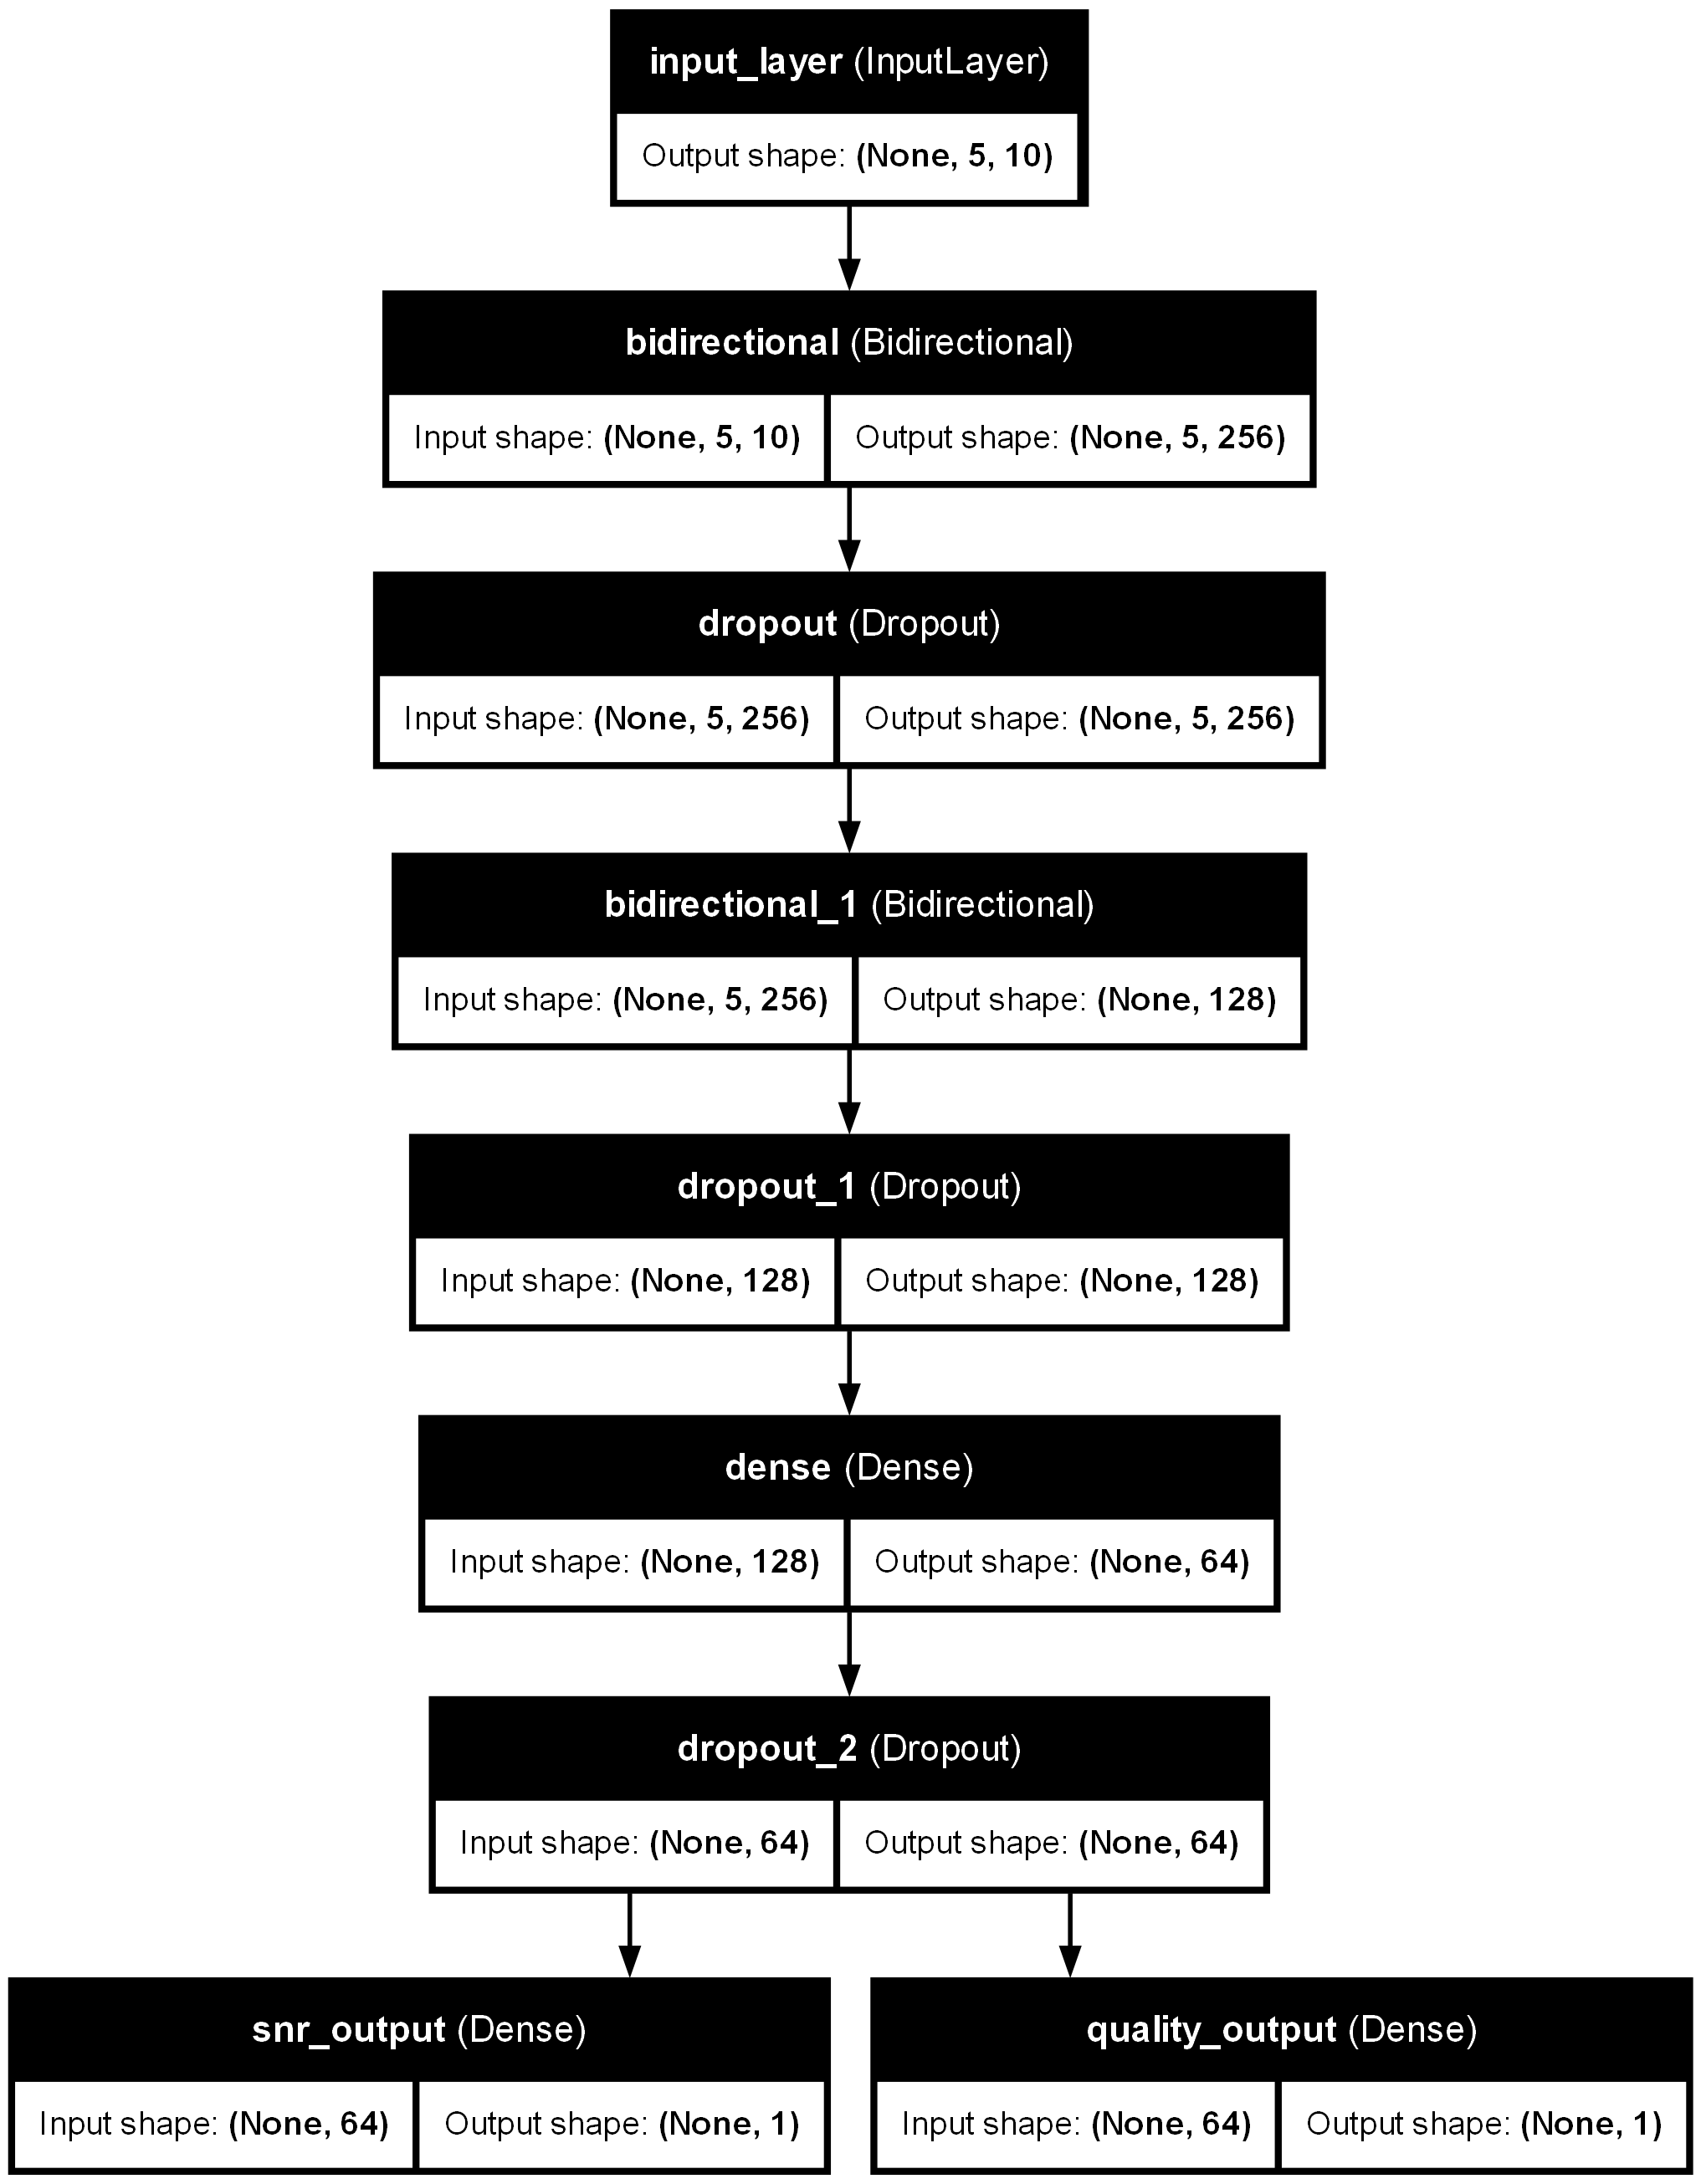

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Model Training

In [14]:
# Training Setup
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model Training
history = model.fit(
    X_train, [y_train_snr, y_train_quality],
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 59.4809 - quality_output_mae: 6.1533 - snr_output_mae: 1.8843 - val_loss: 12.5156 - val_quality_output_mae: 2.8017 - val_snr_output_mae: 0.5323
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.6843 - quality_output_mae: 2.6240 - snr_output_mae: 0.6364 - val_loss: 11.5362 - val_quality_output_mae: 2.6933 - val_snr_output_mae: 0.4169
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.6134 - quality_output_mae: 2.6012 - snr_output_mae: 0.5873 - val_loss: 6.1247 - val_quality_output_mae: 1.9201 - val_snr_output_mae: 0.2548
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5764 - quality_output_mae: 1.7648 - snr_output_mae: 0.5425 - val_loss: 1.9752 - val_quality_output_mae: 1.0540 - val_snr_output_mae: 0.2586
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4951 - quality_output_mae: 1.1556 - snr_output_mae: 0.4590 - val_loss: 2.1810 - val_quality_output_mae: 1.0701 - val_snr_output_mae: 0

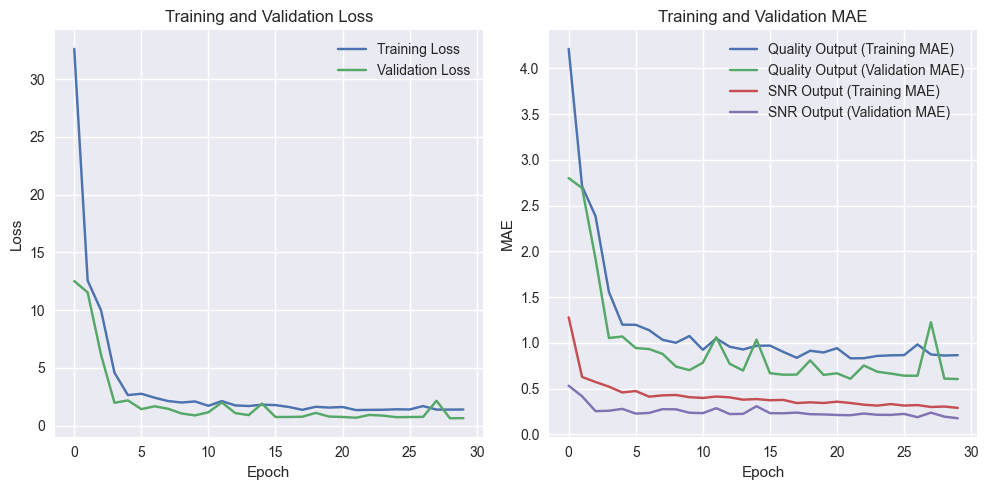

In [17]:
# Training and validation loss plots
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['quality_output_mae'], label='Quality Output (Training MAE)')
plt.plot(history.history['val_quality_output_mae'], label='Quality Output (Validation MAE)')
plt.plot(history.history['snr_output_mae'], label='SNR Output (Training MAE)')
plt.plot(history.history['val_snr_output_mae'], label='SNR Output (Validation MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step


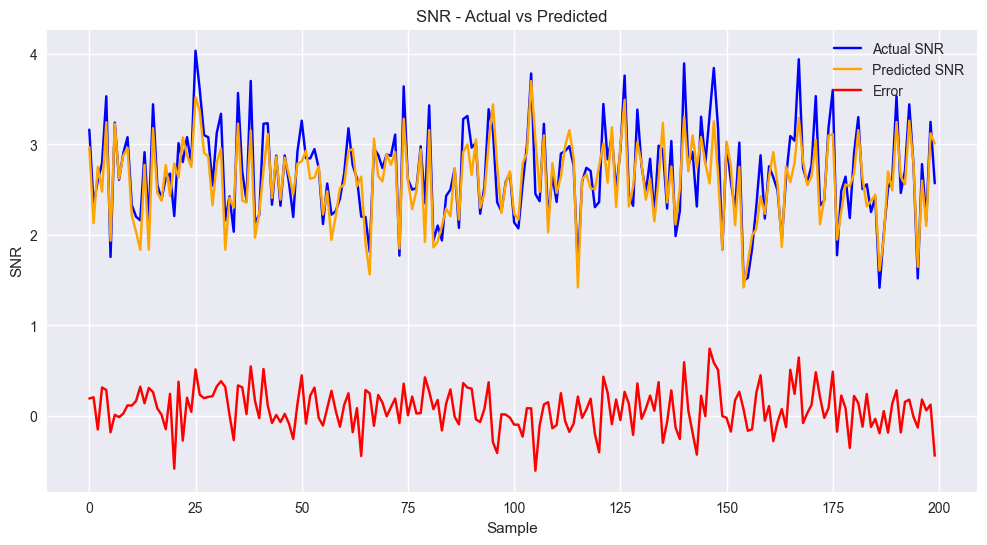

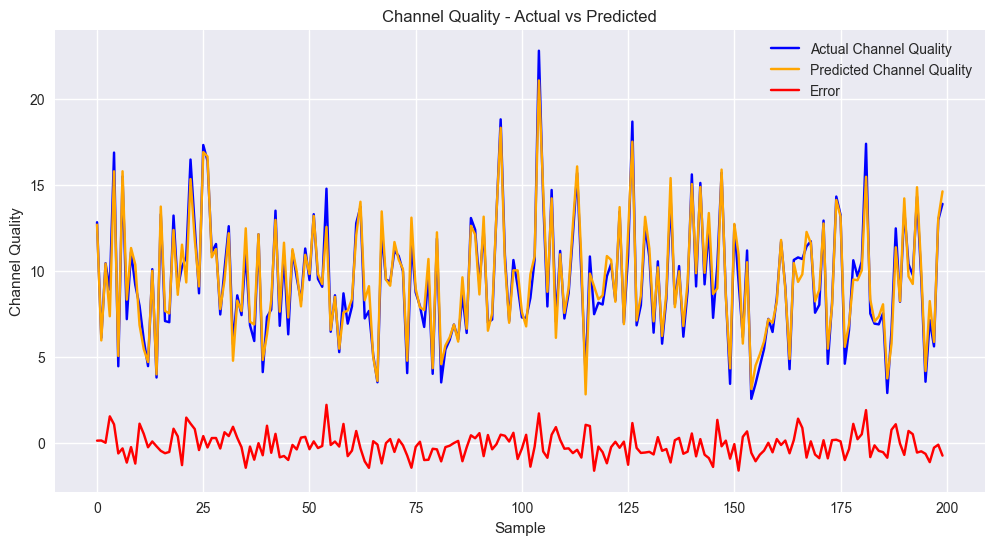

In [ ]:
y_pred_snr, y_pred_quality = model.predict(X_test)

# Actual vs Predicted SNR
plt.figure(figsize=(12, 6))
plt.plot(y_test_snr, label='Actual SNR', color='blue')
plt.plot(y_pred_snr, label='Predicted SNR', color='orange')
plt.plot(y_test_snr - y_pred_snr.reshape((-1,)), label='Error', color='red')
plt.xlabel('Sample')
plt.ylabel('SNR')
plt.title('SNR - Actual vs Predicted')
plt.grid(True)
plt.legend()
plt.show()

# Actual vs Predicted Channel Quality
plt.figure(figsize=(12, 6))
plt.plot(y_test_quality, label='Actual Channel Quality', color='blue', )
plt.plot(y_pred_quality, label='Predicted Channel Quality', color='orange')
plt.plot(y_test_quality - y_pred_quality.reshape((-1,)), label='Error', color='red')
plt.xlabel('Sample')
plt.ylabel('Channel Quality')
plt.title('Channel Quality - Actual vs Predicted')
plt.grid(True)
plt.legend()
plt.show()